In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import pdb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import nltk;
from nltk.corpus import stopwords;

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avichanales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

import spacy
nlp  = spacy.load('en_core_web_md')

### Load Validation Dataset and Model

In [167]:
file_name = '/Users/avichanales/Dropbox/Insight/Project/insight_project/data/interim/charity_data_cleaned.csv'
all_charity = pd.read_csv(file_name)

In [168]:
file_name = '/Users/avichanales/Dropbox/Insight/Project/insight_project/data/interim/validation_set_not_cleaned.csv'
validation_set = pd.read_csv(file_name)

In [169]:
with open('/Users/avichanales/Dropbox/Insight/Project/insight_project/data/processed/charity_model_min_0_max_0.5.pickle', 'rb') as handle:
    charity_model = pickle.load(handle)

In [170]:
def preprocess_spacy(raw_text):
    
    doc = nlp(raw_text)
    
    #Remove organizations and people from documnet text
    tokens_ner = [entity.text for entity in doc.ents if entity.label_ in {'DATE', 'PERSON', 'ORG'}]

    for term in tokens_ner:
        raw_text = raw_text.replace(term,"")
    
    #Re-convert preprocessed text to spacy object    
    doc = nlp(raw_text)


    #Remove stopwords and lemmatize
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

    return tokens

In [171]:
def process_embed_text(text,charity_docs_dict,charity_model_tfidf,charity_tfidf_emb_vecs):
    
    text_pre = preprocess_spacy(text)
     
    #Convert docs into tf-idf vectors
    doc_corpus = charity_docs_dict.doc2bow(text_pre)
    doc_tfidf  = charity_model_tfidf[doc_corpus]
    doc_vec   = np.vstack([sparse2full(doc_tfidf, len(charity_docs_dict))])
    
    # sum of glove vectors linearlly weighted by tfidf 
    art_emb = np.dot(doc_vec, charity_tfidf_emb_vecs)
    
    
    return art_emb

In [172]:
def compute_similarity_output_n(art_emb,charity_docs_emb,topn):
    
    #compute cosine distance from article embedding to all charities
    sim_to_charities = cosine_similarity(art_emb,charity_docs_emb)
    
    #find topN similarity scores
    sim_scores_sorted = -np.sort(-sim_to_charities).flatten()
    topN_scores = sim_scores_sorted[:topn]
    
    #find topN indices
    indices_sorted = (-sim_to_charities).argsort().flatten()
    topN_indices = indices_sorted[:topn].flatten()
    
    return topN_scores, topN_indices

In [173]:
def topN_ranked_charities(charity_df, topN_scores, topN_indices):
    
    charity_df_slim = charity_df[['name','subcategory','score','description']]
    
    #Extract topN charities and info
    similar_charities = charity_df_slim.iloc[topN_indices].reset_index(drop=True)
    
    #Add their similarity scores
    similar_charities['sim_score'] = topN_scores
    
    return similar_charities

In [178]:
def get_headline_rank(df):
    
    headline = df['title']
    charity_name = df['charity']
    n_charities = df['n_charities']
    
    print(charity_name)
    headline_emb = process_embed_text(headline,
                                      charity_model['charity_docs_dict'],
                                      charity_model['charity_model_tfidf'],
                                      charity_model['charity_tfidf_emb_vecs'])
    
    topN_scores, topN_indices = compute_similarity_output_n(headline_emb,charity_model['charity_docs_emb'],n_charities)
    
    ranked_charities = topN_ranked_charities(all_charity, topN_scores, topN_indices)
    
    rank = ranked_charities[ranked_charities['name'] == charity_name].index.values.astype(int)[0]
    
    return rank

In [179]:
validation_set['headline_length'] = validation_set.apply(lambda x: len(x['title'].split(" ")),axis=1)

In [180]:
validation_set_trimmed = validation_set[validation_set['headline_length'] >3]

In [222]:
exclude ={"FIRST", "ECHO", "ICA", "JOIN", 'Lumberyard', 'Leaven', 'LEAP', 
          'Mouse', 'The Mount','MATTER','making change','NPR','Neighbors',
          'NAF','Our Kids','Puente','Public Knowledge','Provide','ProPublica','PRISM', 
          'Polaris','Pillars','PATH','PAI','The Rose', 'Roca','Rare','RAFT', 'Step Up',
          'STEP','STARS','SPUR','SOME','SMART','SHARE', 'Second Chance','SBP','SAGE',
          'Trail Blazers','USO','Unbound','Ventures','World Vision','The Ark','Amara',
          'Alternatives','ACCESS','Breakthrough','Bottom Line','Commonweal','Commentary',
          'CLASP',"CET",'Ceres','Centro','Center Stage','CARE','DREAM','Demos','Equest',
          'Endeavor','Fulfill','FIRST','HERE'}

In [224]:
validation_set_use = validation_set_trimmed[~validation_set_trimmed.charity.isin(exclude)]

In [181]:
validation_set_trimmed['n_charities'] = np.shape(charity_model['charity_docs_emb'])[0]

validation_set_trimmed['rank'] = validation_set_trimmed.apply(get_headline_rank,axis=1)


Syracuse Stage
Syracuse Stage
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zoo Atlanta
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of America
Zionist Organization of Americ

Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute of International Education
Institute for Women's Policy Research
Institute for Women's Policy Research
Institute for Women's Policy Research
Institute for Women's Policy Research
Institute for Transportation and Development Policy
Institute for Quality Education
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
Institute for Policy Studies
I

ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA
ICA


Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
Los Angeles County Museum of Art
The Los Angeles Conservancy
The Los Angeles Conservancy
The Los Angeles Conservancy
Los Angeles Chamber Orchestra
Los Angeles Chamber Orchestra
Los Angeles Chamber Orchestra
Los Angeles Chamber Orchestra
Los 

Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
Mouse
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Mount
The Moun

Mexican American Legal Defense and Educational Fund
Mexican American Legal Defense and Educational Fund
Mexican American Legal Defense and Educational Fund
Mexican American Legal Defense and Educational Fund
Mexican American Legal Defense and Educational Fund
Mexican American Legal Defense and Educational Fund
Metropolitan Planning Council
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolitan Museum of Art
Metropolit

MATTER
MATTER
MATTER
MATTER
MATTER
MATTER
MATTER
MATTER
Martha's Table
Mark Morris Dance Group
Mark Morris Dance Group
Marine Biological Laboratory
Marine Biological Laboratory
Marine Biological Laboratory
Marine Biological Laboratory
MapLight
MAP International
Manna Food Center
MANNA
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Manhattan Institute for Policy Research
Management Leadership for Tomorrow
Maltz Museum of Jewish Heritage
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making change
making ch

NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR


NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR
NPR


New York Road Runners
New York Road Runners
New York Road Runners
New York Road Runners
New York Road Runners
New York Public Radio
New York Public Radio
New York Public Radio
New York Public Radio
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
The New York Public Library
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic
New York Philharmonic


Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors
Neighbors


Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resources Defense Council
Natural Resour

National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Rev

National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Review Institute
National Rev

National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National Immigration Law Center
National

National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center for Transgender Equality
National Center 

NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAF
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fund
NAACP Legal Defense and Educational Fun

Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Counsel
Public Agenda
Public Advocates
Public Advocates
Public Advocates
Public Advocates
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Provide
Prov

Produce for Better Health Foundation
Prichard Committee for Academic Excellence
Prevent Child Abuse America
Prevent Blindness
Preemptive Love Coalition
Preemptive Love Coalition
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Prairie Public Broadcasting
Portland Art Museum
Port Discovery Children's Museum
Population Reference Bureau
Population Reference Bureau
Population Reference Bureau
Population Reference Bureau
Population Reference Bureau
Population Reference Bureau
Population Media Center
Population Council
Population Council
Population Council
Population Council
Population Council
Population Council
Pollinator Partnership
PolicyLink
PolicyLink
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Polaris
Po

Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Institute for International Economics
Peterson Inst

Partners Worldwide
Partners In Health
Partners In Health
Parkinson's Foundation
Parkinson's Foundation
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Park Avenue Armory
Parent Project Muscular Dystrophy
Parent Project Muscular Dystrophy
Parent Project Muscular Dystrophy
Parent Project Muscular Dystrophy
Palm Beach Zoo
Palm 

Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RAND Corporation
RA

Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law

Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Poverty Law Center
Southern Environmental Law Center
Southern Environmental Law Center
Southern Environmental Law Center
Southern Environmental Law Center
Southern Environmental L

San Francisco Museum of Modern Art
San Francisco Museum of Modern Art
San Francisco Museum of Modern Art
San Francisco Museum of Modern Art
San Francisco Museum of Modern Art
San Francisco Museum of Modern Art
San Francisco AIDS Foundation
San Francisco AIDS Foundation
San Francisco AIDS Foundation
San Francisco AIDS Foundation
San Diego Zoo Global
San Diego Zoo Global
San Diego Symphony Orchestra
San Diego Natural History Museum
San Diego Natural History Museum
San Diego Natural History Museum
San Diego Natural History Museum
San Diego Natural History Museum
San Diego Natural History Museum
San Diego Humane Society 
San Diego Humane Society 
San Antonio Humane Society
San Antonio Humane Society
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Samaritan's Purse
Salvador Dalí Museum
Salvador Dalí Museum
Salk Institute for Biological Studies

Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tax Foundation
Tahirih Justice Center
Tahirih Justice Center
Tahirih Justice Center
Tahirih Justice Center
Tahirih Justice Center
Tahirih Justice

Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
Ventures
V

WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHYY
WHW
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of American Art
Whitney Museum of Ame

Animal Rescue League of Boston
Animal Legal Defense Fund
Animal Legal Defense Fund
Animal Legal Defense Fund
Angelman Syndrome Foundation
Angel Foundation
Anera
And Justice for All
And Justice for All
And Justice for All
And Justice for All
And Justice for All
And Justice for All
And Justice for All
Amref Health Africa
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amnesty International USA
Amn

American Humanist Association
American Humane
American Humane
American Humane
American Humane
American Humane
American Humane
American Humane
American Humane
American Humane
American Humane
American Horticultural Society
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Association
American Heart Associat

American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Association for the Advancement of Science
American Ass

Access Fund
Access Fund
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
ACCESS
Acadia Center
Academy of American Poets
Academy of American Poets
Academy of American Poets
Academy of Achievement
Academy of Achievement
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
AAA Foundation for Traffic Safety
A Place Called Home
A Noise Within
A Noise Within
A Noise Within
Butler Institute of American Art
Butler Institute of American Art
Business Executives for National Security
Business Executives for National Security
Buffalo Bayou Partnership
Bruce Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Museum
Brooklyn Mus

Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on For

Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on Foreign Relations
Council on For

Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal
Commonweal

Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary
Commentary

Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
Church World Service
CHUM
CHUM
CHUM
CHUM
CHUM
CHUM
CHUM
Chrysalis
Chrysalis
Chrysalis
Chrysalis
Chrysalis
Chrysalis
Chrysalis
Christian Freedom International
ChildSafe
ChildSafe
ChildSafe
Children's Museum of Pittsburgh
Children's Museum of Manhattan
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Children's Defense Fund
Chi

Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Policy Priorities
Center on Budget and Poli

Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Science in the Public Interest
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Center for Responsive Politics
Ce

Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for Investigative Reporting
Center for International Policy
Center for International Policy
Center for International Policy
Center for International Policy
Center for International Policy
Center for International Policy
Center for International Environmental Law
Center for International Environmental Law
Center for Inquiry
Center for Inquiry
Center for Inquiry
Center for Inquiry
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center for Individual Rights
Center

Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Global Development
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center for Food Safety
Center fo

Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for American Progress
Center for Ame

Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New American Security
Center for a New Ame

Canine Companions for Independence
Cancer Support Community
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for Tobacco-Free Kids
Campaign for College Opportunity
Campaign for College Opportunity
Campaign for College Opportunity
California Trout
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Community Foundation
California Charter Schools Association
California Charter Schools Association
California Charter Schools Association
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Caldera
Calde

Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics and Public Policy Center
Ethics a

Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electronic Frontier Foundation
Electron

Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends of the Earth
Friends for Life
Friends for Life
Friends for Life
Freedom From Religion Foundation
Freedom From Religion Foundation
Freedom From Religion Foundation
Freedom From Religion Foundation
Freedom From Religion Foundation
Freedom From Religion Founda

Fisher House Foundation
Fisher House Foundation
Fisher House Foundation
First Things First
First Things First
First Descents
First Descents
First Descents
First Book
First Book
First Book
First Book
First Book
First Book
First Book
First Book
First Book
First Book
First Book
First Book
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
FIRST
Film Society of Lincoln Center
Film Society of Lincoln Center
Film Society of Lincoln Center
Film Society of Lincoln Ce

Girl Scouts of the USA
Girl Scouts of the USA
Girl Scouts of the USA
Girl Scouts of the USA
Girl Scouts of the USA
Girl Scouts of the USA
Girl Scouts of Greater New York
Girl Scouts of Greater Atlanta
The Gilmore
The Gilmore
The Gilmore
Georgia Historical Society
Georgia Historical Society
George W. Bush Presidential Center
George W. Bush Presidential Center
George W. Bush Presidential Center
George W. Bush Presidential Center
George W. Bush Presidential Center
George W. Bush Presidential Center
George Street Playhouse
George Street Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Geffen Playhouse
Gary Sinise Foundation
Gary Sinise Foundation
Hyde Park Art Center
Hunter Museum of American Art
Hunger Task Force
Hunger Free America
Hunger Free America
Hunger Free America
Humane Society Silicon Valley
Humane Society of New York
Humane Society of New York
Humane Society Interna

Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights Watch
Human Rights

The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
The Heritage Foundation
HERE
HERE
HERE
H

In [226]:
np.shape(validation_set_use)

(13299, 6)

In [225]:
validation_set_use['rank'].mean()

1738.072110685014

In [182]:
validation_set_trimmed['rank'].mean()

2543.281688551112

In [85]:
validation_set_trimmed['rank'].mean()

2647.42489626556

In [82]:
validation_set_trimmed['rank'].mean()

2654.5051777016056

In [19]:
validation_set_trimmed['rank'].mean()

2674.120151542486

In [84]:
validation_set_trimmed['rank'].mean()

2174.871382636656

In [62]:
validation_set['rank'].mean()

2176.1396825396823

In [87]:
validation_set_trimmed['n_charities'].mean()/2

2841.0

In [229]:
rank_by_charity = validation_set_use.groupby('charity')['rank'].mean().reset_index()

In [230]:
rank_by_charity['rank'].mean()

1829.9503007303686

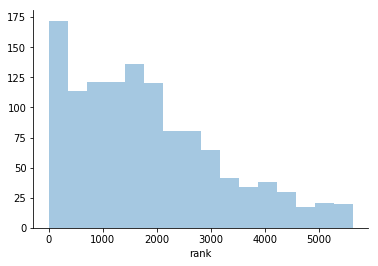

In [231]:
sns.distplot(rank_by_charity['rank'], kde = False)
sns.despine()

In [91]:
rank_by_charity.sort_values(["rank"], axis=0, 
                 ascending=False, inplace=True)

In [92]:
def get_headlines(charity, df):
    df_sub = df[df['charity'] == charity]
    
    return df_sub

In [93]:
def get_mission_statement(charity,df):
    df_sub = df[df['name'] == charity]
    
    return df_sub['description'].iloc[0]

In [221]:
get_mission_statement("WHYY", all_charity)

'WHYY provides news and information, arts and culture and educational programming on three 24/7 broadcast channels, online streaming as well as mobile devices and on-demand cable. WHYY-TV 12.1 offers a varied blend of the best national programming along with locally produced content. Y Info 12.2 specializes in news and public affairs and WHYY 12.3 is a 24/7 PBS Kids channel.'

In [187]:
preprocess_spacy(get_mission_statement("HERE", all_charity))

['build',
 'community',
 'nurture',
 'career',
 'artist',
 'create',
 'innovative',
 'hybrid',
 'live',
 'performance',
 'theatre',
 'dance',
 'music',
 'puppetry',
 'medium',
 'visual',
 'art',
 'artist',
 'residency',
 'support',
 'singular',
 'vision',
 'lead',
 'artist',
 'commission',
 'long',
 'term',
 'development',
 'production',
 'support',
 'program',
 'performance',
 'promote',
 'relationship',
 'local',
 'national',
 'international',
 'artist',
 'space',
 'destination',
 'audience',
 'passionate',
 'ground',
 'break',
 'contemporary',
 'work',
 'creative',
 'process']

In [149]:
doc = nlp(u'January')

for entity in doc.ents:
    print(entity.label_)
    if entity.label_ in {'DATE', 'PERSON', 'ORG'}:
        print('found')

DATE
found


In [126]:
tokens = nlp(u'January')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

January True 6.030409 False


In [138]:
tokens = nlp(u'school')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.is_stop)

school True 6.7380905 False False


In [218]:
a = get_headlines("ProPublica",validation_set_trimmed)

In [219]:
a

,Unnamed: 0,title,charity,headline_length,n_charities,rank
13210,13210,The race to bring NSA surveillance to the Supr...,ProPublica,10,5637,2646
13211,13211,"Richmond Fed President Lacker resigns, admitti...",ProPublica,14,5637,351
13212,13212,Claudia Rankine and Meghan Daum lead 2015 PEN ...,ProPublica,13,5637,3674
13213,13213,The one day all year when companies think they...,ProPublica,17,5637,1927
13214,13214,Trump Strategist Stephen Bannon Says Media Sho...,ProPublica,16,5637,600
13215,13215,Here Is How to Fend Off a Hijacking of Home De...,ProPublica,16,5637,4839
13216,13216,Trust Records Show Trump Is Still Closely Tied...,ProPublica,16,5637,619
13217,13217,We Rounded Up Politics Stories You Shouldn’t M...,ProPublica,13,5637,120
13218,13218,Opposing Views on What to Do About the Data We...,ProPublica,16,5637,2053
13219,13219,Pulitzer Prizes: New York Times Wins 3 Daily N...,ProPublica,20,5637,4026


In [220]:
a['rank'].mean()

2550.131205673759

In [143]:
a['title'].iloc[0]

'These LAUSD students are not heading back to school - LA Times'

In [144]:
preprocess_spacy(a['title'].iloc[0])

> <ipython-input-142-cd3776832529>(13)preprocess_spacy()
-> doc = nlp(raw_text)
(Pdb) raw_text
'These LAUSD students are not heading back to '
(Pdb) tokens_ner
['school - LA Times']
(Pdb) exit()


BdbQuit: 

In [96]:
rank_by_charity

,charity,rank
772,National Alopecia Areata Foundation,5663.000000
140,Boston Children's Museum,5653.000000
600,JCC Association of North America,5619.200000
1071,Sierra Club Foundation,5610.000000
299,Commonwealth,5508.187638
1194,Trees for the Future,5477.000000
832,Network for Teaching Entrepreneurship,5476.000000
129,Bet Tzedek,5471.000000
720,Milwaukee Symphony Orchestra,5470.000000
547,Hunter Museum of American Art,5460.000000


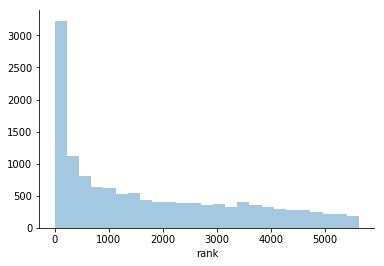

In [232]:
sns.distplot(validation_set_use['rank'],kde = False)
sns.despine()